Plan: Test 1-D convolutions on torque, speed and RPM. Also make model take multiple inputs

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular

In [3]:
import os
files = os.listdir("dataset")

import csv
from tqdm import tqdm
class Route:
    def __init__(self, phi, v, M):
        self.phi = phi
        self.v = v
        self.M = M
    def __len__(self):
        return len(self.phi)
    
routes = []

allRows = 0

maxAngle = 0
maxSpeed = 0
maxTorque = 0

for file in files:
    path = os.path.join("dataset", file)
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        phi = [] # Steering angle
        v = [] # Speed
        M = [] # Output torque
        for row in spamreader:
            phi.append(float(row[1]))
            v.append(float(row[2]))
            M.append(float(row[3]))

            maxAngle = max(abs(float(row[1])), maxAngle)
            maxSpeed = max(abs(float(row[2])), maxSpeed)
            maxTorque = max(abs(float(row[3])), maxTorque)
        routes.append(Route(np.array(phi, dtype=np.float32), np.array(v, dtype=np.float32), np.array(M, dtype=np.float32)))
        allRows += len(phi)


print(allRows)
print(maxAngle, maxSpeed, maxTorque)

330394
16.049999237060547 34.94847106933594 1.0


Now we have everything stored in routes. Time to generate some test data

In [4]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

prev_data = 1000
fwd_data = 100

input_length = 3 * prev_data + fwd_data

all_routes = len(routes)
print(f"There are {all_routes} routes")

train_routes = routes[0:12]
test_routes = routes[12:14]

# Don't actually sample every 1/100 of a s(controlsd frequency)
skip_times = 10

def caddy_dataset(train):
    i_data = []
    o_data = []
    routes = train_routes if train else test_routes
    for route in tqdm(routes):
        for idx in range(prev_data, len(route.v)-fwd_data+1, skip_times):
            phi = route.phi[idx-prev_data : idx]/maxAngle
            v = route.v[idx-prev_data : idx]/maxSpeed
            M = route.M[idx-prev_data : idx+fwd_data]/maxTorque

            o = route.phi[idx+fwd_data-1 : idx+fwd_data]/maxAngle
        
            data_input = (phi, v, M)
            i_data.append(data_input)
            o_data.append(o)
    return SimDataset(len(i_data), i_data, o_data)


train_set = caddy_dataset(True)
test_set = caddy_dataset(False)

print(len(train_set), len(test_set))

 33%|███▎      | 4/12 [00:00<00:00, 33.52it/s]

There are 14 routes


100%|██████████| 2/2 [00:00<00:00, 26.11it/s]

25760 5746


In [6]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False)

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 4, kernel_size=20, stride=1),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2),
            
            nn.Conv1d(4, 4, kernel_size=10),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            
            nn.Conv1d(4, 2, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),
        )
        self.linear_stack = nn.Sequential(
            nn.Linear(366, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Tanh()
        )

    def forward(self, phi, v, M):
        phi2 = phi.unsqueeze(1)
        v2 = v.unsqueeze(1)
        M2 = M.unsqueeze(1)
        conv_phi = self.conv(phi2)
        conv_v = self.conv(v2)
        conv_M = self.conv(M2)
#         print(conv_phi.shape, conv_v.shape, conv_M.shape)
        # Total length = 4*(59, 59, 65) = 100
        x = torch.cat([torch.flatten(conv_phi, start_dim=1), torch.flatten(conv_v, start_dim=1), torch.flatten(conv_M, start_dim=1)], dim=1)
#         print(x.shape)
        return self.linear_stack(x)

In [9]:
#Dimenstions DEBUG
model = NeuralNetwork()
for p in model.parameters():
    print(p.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print()
print(model)
torch_input = (torch.randn((4,prev_data,)), torch.randn((4,prev_data,)), torch.randn((4,prev_data+fwd_data,)))
model(*torch_input)

torch.Size([4, 1, 20])
torch.Size([4])
torch.Size([4, 4, 10])
torch.Size([4])
torch.Size([2, 4, 5])
torch.Size([2])
torch.Size([32, 366])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([1, 16])
torch.Size([1])
13635

NeuralNetwork(
  (conv): Sequential(
    (0): Conv1d(1, 4, kernel_size=(20,), stride=(1,))
    (1): ReLU()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (3): Conv1d(4, 4, kernel_size=(10,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(4, 2, kernel_size=(5,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_stack): Sequential(
    (0): Linear(in_features=366, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
 

tensor([[-0.1217],
        [-0.1214],
        [-0.1222],
        [-0.1222]], grad_fn=<TanhBackward>)

In [10]:
from tqdm import tqdm
import time

def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for X, y in tqdm(dataloader):
        # Compute prediction and loss
        pred = model(*X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        time.sleep(0.1)
    if debug:
        loss = loss.item()*100
        print(f"Train loss: {loss}")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(*X)
            test_loss += loss_fn(pred, y).item()*100

    test_loss /= num_batches
    print(f"Test  loss: {test_loss} \n")

model = NeuralNetwork()
for p in model.parameters():
    print(p.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

torch.Size([4, 1, 20])
torch.Size([4])
torch.Size([4, 4, 10])
torch.Size([4])
torch.Size([2, 4, 5])
torch.Size([2])
torch.Size([32, 366])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([16, 32])
torch.Size([16])
torch.Size([1, 16])
torch.Size([1])
13635


In [12]:
epochs = 30
print(len(train_dataloader))
print(len(test_dataloader))
skip = 1
for t in range(epochs):
    if t%skip == 0:
        print(f"Epoch {t}")
    train_loop(train_dataloader, model, loss_fn, optimizer, t%skip==0)
    if t%skip == 0:
        test_loop(test_dataloader, model, loss_fn)

  0%|          | 1/402 [00:00<00:50,  7.91it/s]

402
90
Epoch 0


100%|██████████| 402/402 [00:50<00:00,  7.96it/s]


Train loss: 0.14827947597950697


  0%|          | 1/402 [00:00<00:49,  8.03it/s]

Test  loss: 0.12607563021851498 

Epoch 1


100%|██████████| 402/402 [00:50<00:00,  7.96it/s]


Train loss: 0.15666792169213295


  0%|          | 1/402 [00:00<00:47,  8.47it/s]

Test  loss: 0.11650332438875921 

Epoch 2


100%|██████████| 402/402 [00:50<00:00,  8.01it/s]


Train loss: 0.15153546119108796


  0%|          | 1/402 [00:00<00:49,  8.06it/s]

Test  loss: 0.11652285378659144 

Epoch 3


100%|██████████| 402/402 [00:50<00:00,  8.02it/s]


Train loss: 0.12037691194564104


  0%|          | 1/402 [00:00<00:48,  8.24it/s]

Test  loss: 0.10073221050940144 

Epoch 4


100%|██████████| 402/402 [00:50<00:00,  8.02it/s]


Train loss: 0.06781538832001388


  0%|          | 1/402 [00:00<00:49,  8.14it/s]

Test  loss: 0.10685693797616598 

Epoch 5


100%|██████████| 402/402 [00:50<00:00,  7.94it/s]


Train loss: 0.0846816401463002


  0%|          | 1/402 [00:00<00:49,  8.05it/s]

Test  loss: 0.09822591401947041 

Epoch 6


100%|██████████| 402/402 [00:50<00:00,  7.92it/s]


Train loss: 0.10910187847912312


  0%|          | 1/402 [00:00<00:49,  8.08it/s]

Test  loss: 0.09613517810875136 

Epoch 7


100%|██████████| 402/402 [00:50<00:00,  7.91it/s]


Train loss: 0.13701171847060323


  0%|          | 1/402 [00:00<00:49,  8.14it/s]

Test  loss: 0.10032936901552603 

Epoch 8


100%|██████████| 402/402 [00:50<00:00,  7.89it/s]


Train loss: 0.11431111488491297


  0%|          | 1/402 [00:00<00:50,  7.90it/s]

Test  loss: 0.08842486828345703 

Epoch 9


100%|██████████| 402/402 [00:50<00:00,  7.92it/s]


Train loss: 0.10606184368953109


  0%|          | 1/402 [00:00<00:50,  8.02it/s]

Test  loss: 0.08488313210869415 

Epoch 10


100%|██████████| 402/402 [00:50<00:00,  7.91it/s]


Train loss: 0.12750603491440415


  0%|          | 1/402 [00:00<00:49,  8.03it/s]

Test  loss: 0.08736655492814155 

Epoch 11


100%|██████████| 402/402 [00:50<00:00,  7.91it/s]


Train loss: 0.092902168398723


  0%|          | 1/402 [00:00<00:48,  8.19it/s]

Test  loss: 0.0858092965467626 

Epoch 12


100%|██████████| 402/402 [00:50<00:00,  7.93it/s]


Train loss: 0.10367271024733782


  0%|          | 1/402 [00:00<00:49,  8.12it/s]

Test  loss: 0.09035769094932927 

Epoch 13


100%|██████████| 402/402 [00:50<00:00,  7.91it/s]


Train loss: 0.14126563910394907


  0%|          | 1/402 [00:00<00:49,  8.07it/s]

Test  loss: 0.09328244355856441 

Epoch 14


100%|██████████| 402/402 [00:50<00:00,  7.92it/s]


Train loss: 0.08737640455365181


  0%|          | 1/402 [00:00<00:50,  7.87it/s]

Test  loss: 0.07896292716193581 

Epoch 15


100%|██████████| 402/402 [00:50<00:00,  7.94it/s]


Train loss: 0.12335523497313261


  0%|          | 1/402 [00:00<00:49,  8.07it/s]

Test  loss: 0.08971131002504586 

Epoch 16


100%|██████████| 402/402 [00:50<00:00,  7.91it/s]


Train loss: 0.09811768541112542


  0%|          | 1/402 [00:00<00:48,  8.29it/s]

Test  loss: 0.07873817304951242 

Epoch 17


100%|██████████| 402/402 [00:50<00:00,  7.91it/s]


Train loss: 0.11894949711859226


  0%|          | 1/402 [00:00<00:50,  7.91it/s]

Test  loss: 0.08107005846492636 

Epoch 18


100%|██████████| 402/402 [00:50<00:00,  7.91it/s]


Train loss: 0.06245634867809713


  0%|          | 1/402 [00:00<00:48,  8.26it/s]

Test  loss: 0.09034480760520738 

Epoch 19


100%|██████████| 402/402 [00:50<00:00,  7.93it/s]


Train loss: 0.10144028346985579


  0%|          | 1/402 [00:00<00:47,  8.35it/s]

Test  loss: 0.08301431275160415 

Epoch 20


100%|██████████| 402/402 [00:50<00:00,  7.92it/s]


Train loss: 0.05774053861387074


  0%|          | 1/402 [00:00<00:48,  8.30it/s]

Test  loss: 0.07865317138364641 

Epoch 21


100%|██████████| 402/402 [00:50<00:00,  7.90it/s]


Train loss: 0.09113441337831318


  0%|          | 1/402 [00:00<00:49,  8.16it/s]

Test  loss: 0.0778625190125442 

Epoch 22


100%|██████████| 402/402 [00:51<00:00,  7.87it/s]


Train loss: 0.09062604513019323


  0%|          | 1/402 [00:00<00:50,  8.01it/s]

Test  loss: 0.07975928263881037 

Epoch 23


100%|██████████| 402/402 [00:51<00:00,  7.85it/s]


Train loss: 0.09155267616733909


  0%|          | 1/402 [00:00<00:49,  8.14it/s]

Test  loss: 0.07566310885724509 

Epoch 24


100%|██████████| 402/402 [00:51<00:00,  7.86it/s]


Train loss: 0.061778369126841426


  0%|          | 1/402 [00:00<00:49,  8.10it/s]

Test  loss: 0.08478857209815437 

Epoch 25


100%|██████████| 402/402 [00:50<00:00,  7.91it/s]


Train loss: 0.09023604216054082


  0%|          | 1/402 [00:00<00:50,  7.95it/s]

Test  loss: 0.07766532050381 

Epoch 26


100%|██████████| 402/402 [00:51<00:00,  7.82it/s]


Train loss: 0.06437431438826025


  0%|          | 1/402 [00:00<00:49,  8.10it/s]

Test  loss: 0.07375197258726177 

Epoch 27


100%|██████████| 402/402 [00:51<00:00,  7.86it/s]


Train loss: 0.08211217354983091


  0%|          | 1/402 [00:00<00:50,  7.96it/s]

Test  loss: 0.07410152956759299 

Epoch 28


100%|██████████| 402/402 [00:51<00:00,  7.82it/s]


Train loss: 0.0883357715792954


  0%|          | 1/402 [00:00<00:49,  8.07it/s]

Test  loss: 0.07307444290846535 

Epoch 29


100%|██████████| 402/402 [00:51<00:00,  7.81it/s]


Train loss: 0.09360868134535849
Test  loss: 0.08423632704458821 



-0.3 initial angle
-2.2499999712769636 ground truth
-1.7411444395139029


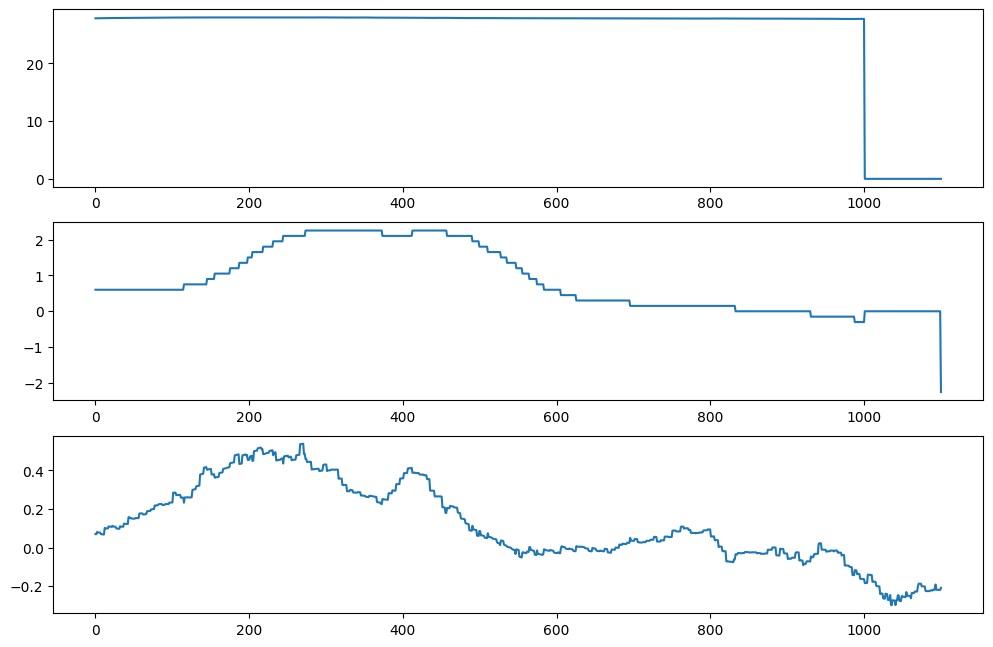

In [22]:
#Make a plot
random_sample = test_set[randrange(len(test_set))]
phi, v, M = random_sample[0]
phi = phi*maxAngle
v = v*maxSpeed
M = M*maxTorque
v.resize(1100)
phi.resize(1100)
phi[-1] = random_sample[1][0]*maxAngle

time = 1100
_, axs = plt.subplots(3)
axs[0].plot(np.linspace(0, time, time), v)
axs[1].plot(np.linspace(0, time, time), phi)
axs[2].plot(np.linspace(0, time, time), M)

print(phi[999], "initial angle")
print(random_sample[1][0]*maxAngle, "ground truth")

torch_data_input = tuple(map(torch.from_numpy, random_sample[0]))
print(model(torch_data_input[0].unsqueeze(0), torch_data_input[1].unsqueeze(0), torch_data_input[2].unsqueeze(0)).item()*maxAngle)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1060 3GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


Really hard to improve upon a basic NN...